In [34]:
import os
import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset
from torch.backends import cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision.models import alexnet
from torchvision.models import resnet18
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm

In [35]:
device = 'cuda' 
num_class = 101 
batch_size = 256    
num_epochs = 20     
step_size =  6     


In [36]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    return

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionando as imagens para 224x224
    transforms.ToTensor(),
])

caltech101_dataset = datasets.Caltech101(
    root='C:/Users/Usuário/Desktop/machine/Trabalho_3',        # Diretório onde o dataset será armazenado
    download=True,        # Baixar o dataset
    transform=transform  
)

Files already downloaded and verified


In [38]:
data_dir = 'C:/Users/Usuário/Desktop/machine/Trabalho_3/caltech101/101_ObjectCategories'

from torch.utils.data import random_split

dataset_size = len(caltech101_dataset)  # Tamanho total do dataset

train_size = int(0.8 * dataset_size)  # 80% para treino
val_size = int(0.1 * dataset_size)    # 10% para validação
test_size = dataset_size - train_size - val_size  # O restante para teste (10%)

# Dividindo o dataset completo em treino, validação e teste
train_dataset, val_dataset, test_dataset = random_split(caltech101_dataset, [train_size, val_size, test_size])

print(f'Tamanho do treino: {len(train_dataset)}')
print(f'Tamanho da validação: {len(val_dataset)}')
print(f'Tamanho do teste: {len(test_dataset)}')

Tamanho do treino: 6941
Tamanho da validação: 867
Tamanho do teste: 869


In [39]:
def custom_collate_fn(batch):
    for i in range(len(batch)):
        if batch[i][0].size(0) == 1:  # Verifica se a imagem tem 1 canal (grayscale)
            batch[i] = (batch[i][0].repeat(3, 1, 1), batch[i][1])  
    return torch.utils.data.dataloader.default_collate(batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)

In [41]:
class Caltech101(nn.Module):
    def __init__(self, num_classes=101):  # 101 classes para o Caltech101
        super(Caltech101, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Saída ajustada para 101 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

In [42]:
from sklearn.metrics import classification_report

# Função para calcular e imprimir o classification report
def classification_report_per_class(outputs, labels):
    return classification_report(labels.cpu(), outputs.cpu(), zero_division=0)

In [43]:
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())

# Obter o número total de classes
num_classes = len(set(all_labels))
print(num_class)

101


In [44]:
import random
from collections import Counter

# Definindo a seed
seed = 42
random.seed(seed)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # Para garantir que os resultados sejam determinísticos
torch.backends.cudnn.benchmark = False  

epoch_loss_train = []
epoch_loss_val = []
epoch_acc_val = []
epoch_acc_train = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciar o modelo
model = Caltech101().to(device)


all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  

num_classes = len(set(all_labels))

class_counts = Counter(all_labels)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Crie uma lista de pesos com um valor para cada classe
weights = np.zeros(num_classes, dtype=np.float32)
for cls, weight in class_weights.items():
    weights[cls] = weight

# Converter para tensor
class_weights_tensor = torch.tensor(weights).to(device)

# Definir a função de perda com pesos
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

for epoch in range(20):  # 20 épocas
    model.train()
    running_loss_train = 0.0
    running_corrects_train = 0

    for inputs, labels in train_dataloader: 
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()  

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss_train += loss.item() * inputs.size(0)  
        running_corrects_train += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_train.append(running_loss_train / len(train_dataloader.dataset))
    epoch_acc_train.append(running_corrects_train / len(train_dataloader.dataset))

    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:  
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  
            loss = criterion(outputs, labels)
            all_preds.append(preds)
            all_labels.append(labels)

            # Estatísticas
            running_loss_val += loss.item() * inputs.size(0) 
            running_corrects_val += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_val.append(running_loss_val / len(val_dataloader.dataset))
    epoch_acc_val.append(running_corrects_val / len(val_dataloader.dataset))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Imprimir as estatísticas de cada época
    print(f"Época {epoch+1}/20")
    print(f"  Treino - Loss: {epoch_loss_train[-1]:.4f}, Acurácia: {epoch_acc_train[-1]:.4f}")
    print(f"  Validação - Loss: {epoch_loss_val[-1]:.4f}, Acurácia: {epoch_acc_val[-1]:.4f}")

Época 1/20
  Treino - Loss: 4.6001, Acurácia: 0.0069
  Validação - Loss: 4.5516, Acurácia: 0.0150
Época 2/20
  Treino - Loss: 4.5875, Acurácia: 0.0156
  Validação - Loss: 4.5905, Acurácia: 0.0046
Época 3/20
  Treino - Loss: 4.5630, Acurácia: 0.0160
  Validação - Loss: 4.5223, Acurácia: 0.0069
Época 4/20
  Treino - Loss: 4.4940, Acurácia: 0.0212
  Validação - Loss: 4.4302, Acurácia: 0.0254
Época 5/20
  Treino - Loss: 4.4007, Acurácia: 0.0259
  Validação - Loss: 4.2572, Acurácia: 0.0461
Época 6/20
  Treino - Loss: 4.2673, Acurácia: 0.0405
  Validação - Loss: 4.1832, Acurácia: 0.0657
Época 7/20
  Treino - Loss: 4.1333, Acurácia: 0.0631
  Validação - Loss: 4.0431, Acurácia: 0.0888
Época 8/20
  Treino - Loss: 4.0034, Acurácia: 0.1076
  Validação - Loss: 3.9333, Acurácia: 0.1165
Época 9/20
  Treino - Loss: 3.8304, Acurácia: 0.1402
  Validação - Loss: 3.8949, Acurácia: 0.1696
Época 10/20
  Treino - Loss: 3.6746, Acurácia: 0.1889
  Validação - Loss: 3.7341, Acurácia: 0.2122
Época 11/20
  Trein

In [45]:
print(classification_report_per_class(all_preds, all_labels))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        51
           1       0.93      0.93      0.93        40
           2       0.56      0.74      0.64        19
           3       0.92      0.81      0.86        72
           4       0.33      1.00      0.50         2
           5       0.90      0.71      0.79        76
           6       0.14      0.33      0.20         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         4
          11       0.33      0.25      0.29         4
          12       0.80      0.21      0.33        19
          13       0.25      0.14      0.18         7
          14       0.00      0.00      0.00         2
          15       0.30      0.33      0.32         9
          16       0.80      0.80      0.80         5
          17       0.00    

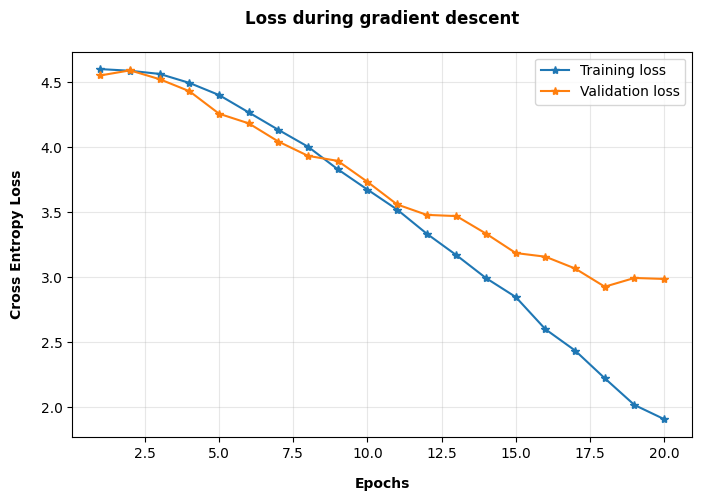

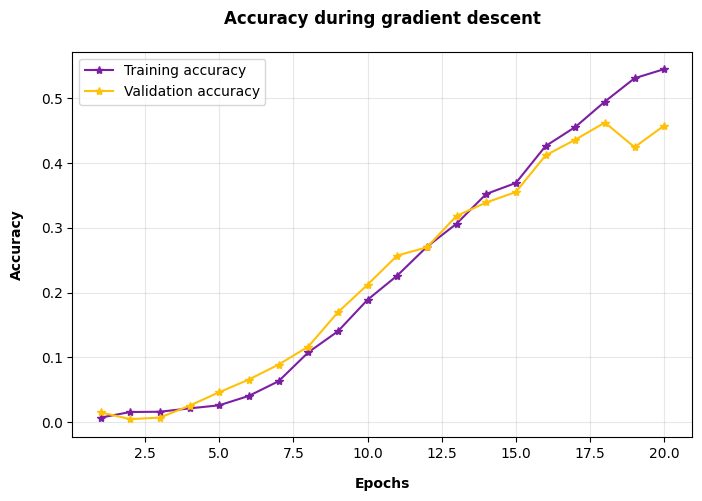

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_loss_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, epoch_loss_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_acc_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, epoch_acc_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

def precision(outputs, labels):
    return precision_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def recall(outputs, labels):
    return recall_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def f1(outputs, labels):
    return f1_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

In [48]:
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    test_running_loss = 0.0
    test_running_corrects = 0
    all_preds = []
    all_labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Predições
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
            
            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += (preds == labels).sum().item()

    test_loss = test_running_loss / len(test_dataloader.dataset)
    test_acc = test_running_corrects / len(test_dataloader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    test_precision = precision(all_preds, all_labels)
    test_recall = recall(all_preds, all_labels)
    test_f1 = f1(all_preds, all_labels)

    print(f"Teste - Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")
    print(f"Precisão: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

    return test_loss, test_acc, test_precision, test_recall, test_f1

In [49]:
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_dataloader, device)

Teste - Loss: 2.3470, Acurácia: 0.4787
Precisão: 0.5217, Recall: 0.4787, F1-Score: 0.4840


In [67]:
def count_zero_precision_recall(y_true, y_pred, num_classes=101):
    precision = []
    recall = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for class_label in range(num_classes):
        precision_value = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall_value = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        precision.append(precision_value)
        recall.append(recall_value)

    precision = np.array(precision)
    recall = np.array(recall)

    zero_precision_classes = [i for i in range(num_classes) if precision[i] == 0]
    zero_recall_classes = [i for i in range(num_classes) if recall[i] == 0]
    
    print(f"Número de classes com Precision = 0: {len(zero_precision_classes)}")
    print(f"Classes com Precision = 0: {zero_precision_classes}")

    print(f"Número de classes com Recall = 0: {len(zero_recall_classes)}")
    print(f"Classes com Recall = 0: {zero_recall_classes}")

    zero_classes = set(zero_precision_classes) & set(zero_recall_classes)
    print(f"Número de classes com Precision e Recall = 0: {len(zero_classes)}")
    print(f"Classes com Precision e Recall = 0: {zero_classes}")
    
count_zero_precision_recall(all_labels.cpu(),all_preds.cpu(), num_classes=101)

Número de classes com Precision = 0: 24
Classes com Precision = 0: [7, 8, 9, 10, 14, 17, 18, 22, 24, 26, 28, 30, 34, 36, 39, 44, 54, 56, 66, 70, 80, 82, 96, 97]
Número de classes com Recall = 0: 24
Classes com Recall = 0: [7, 8, 9, 10, 14, 17, 18, 22, 24, 26, 28, 30, 34, 36, 39, 44, 54, 56, 66, 70, 80, 82, 96, 97]
Número de classes com Precision e Recall = 0: 24
Classes com Precision e Recall = 0: {7, 8, 9, 10, 14, 17, 18, 22, 24, 26, 28, 30, 34, 36, 39, 44, 54, 56, 66, 70, 80, 82, 96, 97}
